In [1]:
%load_ext autoreload
%autoreload 2
from DarkMatter import *
from DarkMatter.Likelihood import PPPCspectra, HDMspectra
from HDMSpectra import HDMSpectra

Welcome to JupyROOT 6.26/08


# Request 1

In [99]:
flx = {}
obs_E = 1e5 #(PeV)
c = "ttbar"
for i, obs_E in enumerate([3e5, 5e5, 1e6]):
    flx[i] = []
    for M in np.logspace(4.5, 12, 50):
        finalstate = 22   # photon
        initialstate = HDM_Channel2Num[c]
        x = np.logspace(-6.,0.,25000)
        
        
        temp, delta = HDMspectra(c, x, M, return_dNdx=True)
        E = x*M
        E = center_pt(E)
        
        total = sum(center_pt(temp)*np.diff(x)*E)+delta*E[-1]
        observable = (E<obs_E)

        vts = sum((center_pt(temp)*np.diff(x)*E)[observable])
        
        if M < obs_E:
            vts+=delta*E[-1]

        flx[i].append([M, total, vts])
    flx[i] = np.asarray(flx[i])    

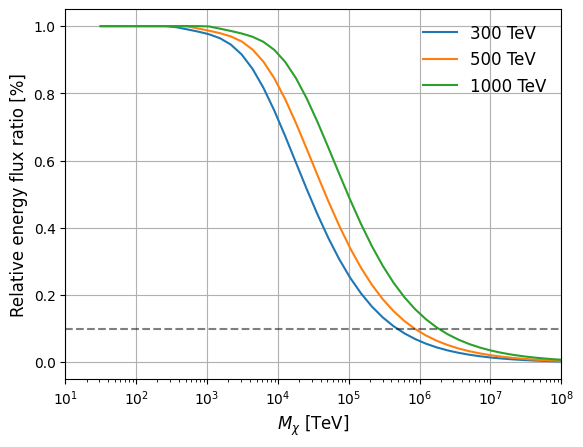

In [101]:
for c, cl in enumerate(["300 TeV", "500 TeV", "1000 TeV"]):
    plt.plot(flx[c][:,0]/1000., flx[c][:,2]/flx[c][:,1], label=cl)
    data = np.asarray([flx[c][:,0]/1000., flx[c][:,2]/flx[c][:,1]]).T
    np.save(f"e_ratio_{c}", data)
plt.xscale("log")
#plt.yscale("log")
plt.axhline(0.1, color="k", ls="--", alpha=0.5)
plt.grid()
plt.legend(ncol=1, fontsize=12, frameon=False)
plt.xlabel("$M_{\chi}$ [TeV]", fontsize=12)
plt.ylabel("Relative energy flux ratio [%]", fontsize=12)
plt.ylim(-0.05,)
plt.xlim(1e1, 1e8)
plt.savefig("ratio_various_cuts_top.pdf")

# Request 2

In [102]:
data = Likelihood.vegas.readData("Segue_1", rawdata=True)

bkg = data[data[:,2] == 0]

N_on = len(bkg)*10

bins = np.linspace(1, 6, 71)

y, x = np.histogram(np.log10(bkg[:,0]), bins, density=True)
minx = min(x[:-1][y>0])
x = center_pt(x)
int_p = interp1d(x[y>0], y[y>0], fill_value="extrapolate", kind="slinear")

def model(val):
    val = np.atleast_1d(val)
    output = []
    for v in val:
        if v < minx:
            output.append(0)
        else:
            v = int_p(v)
            if v < 0:
                output.append(1e-6)
            else:
                output.append(v)
    if len(output) == 1:
        return output[0]
    else:
        return output

gaus = lambda x, mu, s: 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-mu)/(2*s**2.))

from scipy.interpolate import interp1d

E_std= 2;

E_samp = [[np.random.rand(1)[0]*5+1.5, 0, 0, 0]]

for i in trange(N_on):
    u = np.random.rand(1)
    E_old = E_samp[i][0]
    E_new = np.random.randn(1)[0] * E_std + E_old

    A = min(1, (model(E_new)*gaus(E_old, E_new, E_std))/(model(E_old)*gaus(E_new, E_old, E_std)))
    if u < A:
        E_samp.append([E_new, 0, 0, 0])
    else:
        E_samp.append([E_old, 0, 0, 0])

  0%|          | 0/1208260 [00:00<?, ?it/s]

In [103]:
dwarf = "Segue_1"

package="VEGAS"
jSeed=defaultNum[dwarf]

exposure = 50*3600
EA_factor = 10
jProfile_vts = JProfile.generateConvolvedJ(dwarf, package="VEGAS", general=True, seed=defaultNum[dwarf], return_array=True, save_root=False)
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = irf.exposure/exposure
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio*EA_factor
N_off_vts = sum(events[:,2]==0)/t_ratio*EA_factor
alpha = 0.131
z, m_test, y = getArray(irf.Edisp)

VEGAS_EA = np.asarray(getArray(irf.EA))
PROPOSAL_EA = VEGAS_EA
PROPOSAL_EA[1] = VEGAS_EA[1]*EA_factor
irf.EA = ResponseFunction.fakeEA(PROPOSAL_EA.T)

irf.exposure = exposure
mass = np.logspace(4.5, 7.5, 5)


  0%|          | 0/101 [00:00<?, ?it/s]

In [105]:
channel="ttbar"
filename=f"proposal_EA10_50h_{channel}"
Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=False,
                                  useBias=True, verbosity=0, runs=100, filename=filename, test=True, seed=9, 
                                  alpha = alpha, bkg=E_samp)

  0%|          | 0/500 [00:00<?, ?it/s]

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************
  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************


Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).


In [106]:
dwarf = "Segue_1"

package="VEGAS"
jSeed=defaultNum[dwarf]

exposure = 1400*3600
EA_factor = 10
jProfile_vts = JProfile.generateConvolvedJ(dwarf, package="VEGAS", general=True, seed=defaultNum[dwarf], return_array=True, save_root=False)
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = irf.exposure/exposure
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio*EA_factor
N_off_vts = sum(events[:,2]==0)/t_ratio*EA_factor
alpha = 0.131
z, m_test, y = getArray(irf.Edisp)

VEGAS_EA = np.asarray(getArray(irf.EA))
PROPOSAL_EA = VEGAS_EA
PROPOSAL_EA[1] = VEGAS_EA[1]*EA_factor
irf.EA = ResponseFunction.fakeEA(PROPOSAL_EA.T)

irf.exposure = exposure
mass = np.logspace(4.5, 7.5, 5)


  0%|          | 0/101 [00:00<?, ?it/s]

In [107]:
channel="ttbar"
filename=f"proposal_EA10_1400h_{channel}"
Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=False,
                                  useBias=True, verbosity=0, runs=100, filename=filename, test=True, seed=9, 
                                  alpha = alpha, bkg=E_samp)

  0%|          | 0/500 [00:00<?, ?it/s]

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

In [108]:
dwarf = "Segue_1"

package="VEGAS"
jSeed=defaultNum[dwarf]

exposure = 3000*3600
EA_factor = 10
jProfile_vts = JProfile.generateConvolvedJ(dwarf, package="VEGAS", general=True, seed=defaultNum[dwarf], return_array=True, save_root=False)
irf = ResponseFunction.VEGAS.readIRFs(dwarf)
t_ratio = irf.exposure/exposure
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)
N_on_vts = sum(events[:,2]==1)/t_ratio*EA_factor
N_off_vts = sum(events[:,2]==0)/t_ratio*EA_factor
alpha = 0.131
z, m_test, y = getArray(irf.Edisp)

VEGAS_EA = np.asarray(getArray(irf.EA))
PROPOSAL_EA = VEGAS_EA
PROPOSAL_EA[1] = VEGAS_EA[1]*EA_factor
irf.EA = ResponseFunction.fakeEA(PROPOSAL_EA.T)

irf.exposure = exposure
mass = np.logspace(4.5, 7.5, 5)


  0%|          | 0/101 [00:00<?, ?it/s]

In [109]:
channel="ttbar"
filename=f"proposal_EA10_3000h_{channel}"
Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = irf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jProfile=jProfile_vts, addTheta=False, version="all", ext=False, multi=False,
                                  useBias=True, verbosity=0, runs=100, filename=filename, test=True, seed=9, 
                                  alpha = alpha, bkg=E_samp)

  0%|          | 0/500 [00:00<?, ?it/s]

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/dtak/Software/miniconda3/envs/dm/lib/python3.10/site-packages/numpy/core/_methods.p

  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************


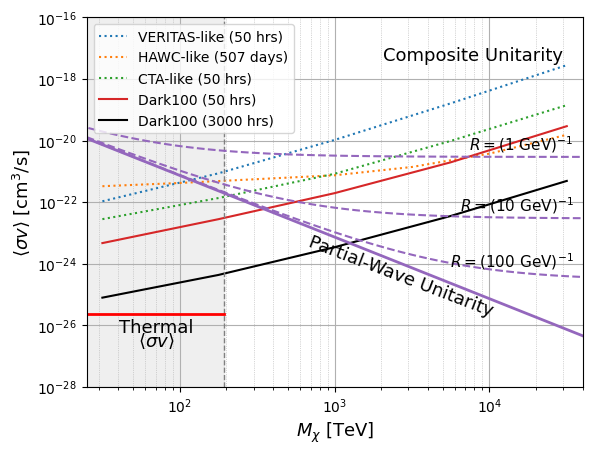

In [115]:
Likelihood.plotExpULcurve(filename="vts_like_ttbar", units="TeV", label="VERITAS-like (50 hrs)", ls = ":", mean_only=True)
Likelihood.plotExpULcurve("hawc_like_ttbar_v2", label="HAWC-like (507 days)", units="TeV", ls = ":", mean_only=True)
Likelihood.plotExpULcurve(f"cta_like_ttbar", label=r"CTA-like (50 hrs)", units="TeV", ls = ":", mean_only=True)
Likelihood.plotExpULcurve(filename=f"proposal_EA10_50h_ttbar", units="TeV", label="Dark100 (50 hrs)", mean_only=True)
Likelihood.plotExpULcurve(filename=f"proposal_EA10_3000h_ttbar", units="TeV", label="Dark100 (3000 hrs)", color="k", mean_only=True)

plotUnitarity()

plt.savefig("ul_v1.pdf")

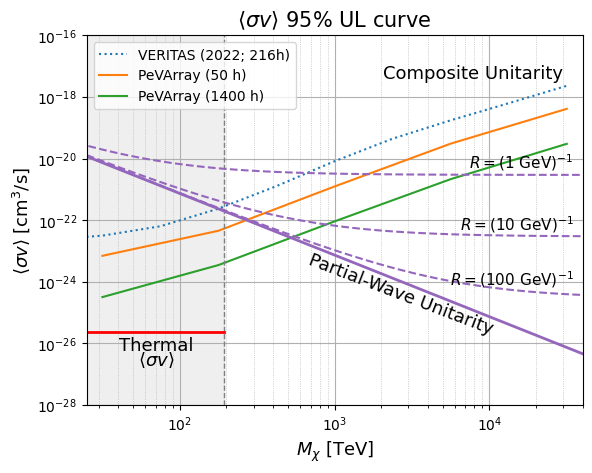

In [98]:
Likelihood.plotULcurve(f"VEGAS_stacked_tt_1D_null", label=r"VERITAS (2022; 216h)", units="TeV", ls=":")
Likelihood.plotExpULcurve(filename=f"proposal_EA10_50h_tt", units="TeV", label="PeVArray (50 h)", mean_only=True)
Likelihood.plotExpULcurve(filename=f"proposal_EA10_1400h_tt", units="TeV", label="PeVArray (1400 h)", mean_only=True)
plotUnitarity()

plt.savefig("ul_v2.pdf")